## AUTHOR: FRANIA CHETTIAR

# Plot 4 game

Plot 4 is a game in which if one were to connect 4 of his moves either horizontally, vertically or diagonally, one records a win. In reinforcement learning setting, we grant reward = 1 for a win, -1 for a lose and 0.5 for a draw. The following game engine object provides five methods.

Board state with X and Os

Scan the board state and give available moves.

Based on which player is making the move, check if one has won the game or a draw has resulted.

THen make a move- Record the move by players and return observation and reward.

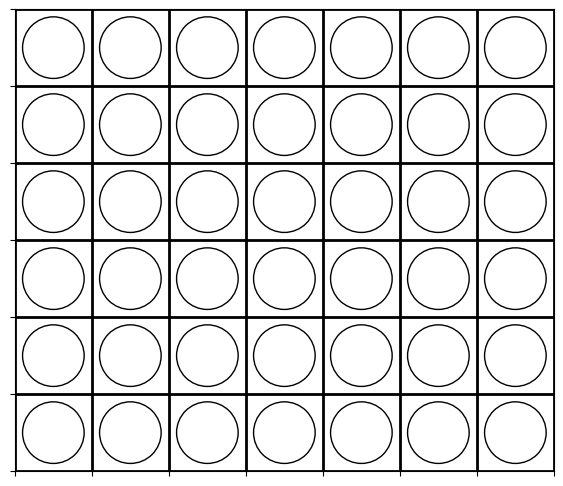

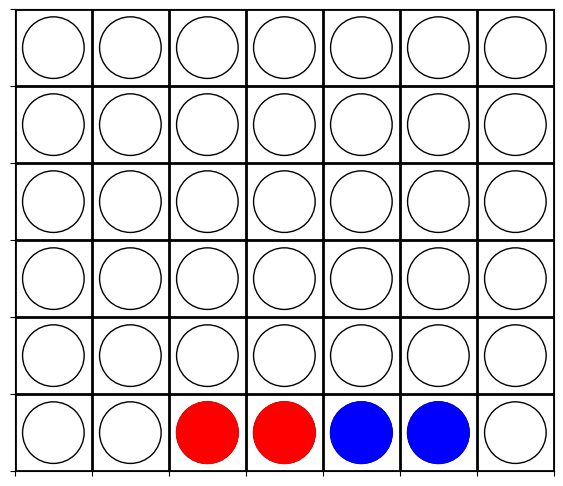

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from itertools import count

# Connect-X Game Engine with Visual Rendering
class connect_x:
    def __init__(self):
        self.board_height = 6
        self.board_width = 7
        self.board_state = np.zeros([self.board_height, self.board_width], dtype=np.int8)
        self.players = {'p1': 1, 'p2': 2}
        self.isDone = False
        self.reward = {'win': 1, 'draw': 0.5, 'lose': -1}

    def render(self):
        fig, ax = plt.subplots(figsize=(7, 6))
        ax.set_xticks(np.arange(-0.5, self.board_width, 1))
        ax.set_yticks(np.arange(-0.5, self.board_height, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(which="major", color="black", linestyle="-", linewidth=2)

        for row in range(self.board_height):
            for col in range(self.board_width):
                # Draw empty grid with white circles
                circle = patches.Circle((col, self.board_height - row - 1), 0.4, edgecolor='black', facecolor='white')
                ax.add_patch(circle)

                # Draw red circle for Player 1 (p1) and blue circle for Player 2 (p2)
                if self.board_state[row, col] == 1:
                    circle = patches.Circle((col, self.board_height - row - 1), 0.4, color='red')
                    ax.add_patch(circle)
                elif self.board_state[row, col] == 2:
                    circle = patches.Circle((col, self.board_height - row - 1), 0.4, color='blue')
                    ax.add_patch(circle)

        ax.set_aspect('equal')
        plt.show()

    def reset(self):
        self.board_state = np.zeros([self.board_height, self.board_width], dtype=np.int8)
        self.isDone = False

    def get_available_actions(self):
        available_cols = [j for j in range(self.board_width) if np.sum(self.board_state[:, j] == 0) != 0]
        return available_cols

    def check_game_done(self, player):
        check = '1 1 1 1' if player == 'p1' else '2 2 2 2'
        for j in range(self.board_width):
            if check in np.array_str(self.board_state[:, j]):
                self.isDone = True
        for i in range(self.board_height):
            if check in np.array_str(self.board_state[i, :]):
                self.isDone = True

        for k in range(self.board_height - 3):
            for d in range(self.board_width - 3):
                diag1 = [self.board_state[k+i, d+i] for i in range(4)]
                diag2 = [self.board_state[k+i, d+3-i] for i in range(4)]
                if diag1 == [self.players[player]] * 4 or diag2 == [self.players[player]] * 4:
                    self.isDone = True

        if self.isDone:
            return self.reward['win']
        elif np.sum(self.board_state == 0) == 0:
            self.isDone = True
            return self.reward['draw']
        else:
            return 0.0

    def make_move(self, a, player):
        if a in self.get_available_actions():
            i = np.sum(self.board_state[:, a] == 0) - 1
            self.board_state[i, a] = self.players[player]
        else:
            print('Move is invalid')
            self.render()

        reward = self.check_game_done(player)
        return self.board_state.copy(), reward

# Testing the visual rendering of the board
env = connect_x()  # Initialize the game
env.reset()         # Reset the board
env.render()        # Render the empty board

# Simulate a few moves to see the colored circles on the board
env.make_move(3, 'p1')  # Player 1 makes a move in column 3
env.make_move(4, 'p2')  # Player 2 makes a move in column 4
env.make_move(2, 'p1')  # Player 1 makes a move in column 2
env.make_move(5, 'p2')  # Player 2 makes a move in column 5
env.render()            # Render the board after moves


# Experience replay

We’ll be using experience replay for training our DQN. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.  

For a brief review of more advanced sampling algorithm mentioned in AlphaGo zero, its sampling procedure can be divided into 3 phases.

Optimization- It checkpoints the deep learning agent by recording its weights every 1000 training iterations.

Evaluation:Evaluate the checkpoints model by letting the two playing against each other for 400 games, the one wins > 55% will become the current best model (with epsilon = 0 = no exploration).

Self-play: They will only use the current best model or player to generate training data for the optimization step.  



In [2]:
import random

# memory block for deep q learning
class replayMemory:
    def __init__(self):
        self.memory = []

    def dump(self, transition_tuple):
        self.memory.append(transition_tuple)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

memory = replayMemory()

In [3]:
# Initialize replay memory
memory = replayMemory()

# Define a sample transition (for testing purposes, replace with actual state, action, reward, next_state)
sample_transition = ('state1', 'action1', 1.0, 'next_state1')
memory.dump(sample_transition)  # Add the sample transition to memory

# Add more transitions if you like
memory.dump(('state2', 'action2', 0.5, 'next_state2'))
memory.dump(('state3', 'action3', -1.0, 'next_state3'))

# Check the memory contents
print("Memory contents:", memory.memory)

# Test sampling (make sure memory has enough transitions for the batch size)
batch_size = 2
if len(memory) >= batch_size:
    sample_batch = memory.sample(batch_size)
    print("Sampled batch:", sample_batch)


Memory contents: [('state1', 'action1', 1.0, 'next_state1'), ('state2', 'action2', 0.5, 'next_state2'), ('state3', 'action3', -1.0, 'next_state3')]
Sampled batch: [('state1', 'action1', 1.0, 'next_state1'), ('state2', 'action2', 0.5, 'next_state2')]


# Deep Q-network

Our model will be using a convolutional neural network that takes into the state as an image of board_state and output the state action function value for all states. In effect, the network is trying to predict the expected return of taking each action given the current input. But be aware that, the game's action space is changing so agent can only take legal actions.  

More advanced way to deal with training a better function approximator for fully observation games like Go and Connect-4 is to preprocess input images. AlphaGo zero separated the training input image into two binary matrix of 0 and 1s made by white and black stones. Also, to handle strategic moves better, it includes the history (last 8 moves of game) as input, plus 1 extra dimension as 0 or 1 indicating whether it is the players turn to make a move, in their case, the input is therfore 19 \* 19 \* 17 (2 * 8 + 1) image vector. The output is a policy vector of 19 \* 19 (the probabilities of making a moves) and a state value scalar.  

For fast experimentation, our DQN will just use a single image map as 6 \* 7 \* 1 with 1 as the moves made by player 1 and 2 as the moves made by player 2.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):

    def __init__(self, outputs):
        super(DQN, self).__init__()
        # 6 by 7, 10 by 11
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv7 = nn.Conv2d(32, 32, kernel_size=5, padding=2)

        linear_input_size = 6 * 7 * 32
        self.MLP1 = nn.Linear(linear_input_size, 50)
        self.MLP2 = nn.Linear(50, 50)
        self.MLP3 = nn.Linear(50, 50)
        self.MLP4 = nn.Linear(50, outputs)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = F.leaky_relu(self.conv6(x))
        x = F.leaky_relu(self.conv7(x))
        # flatten the feature vector except batch dimension
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.MLP1(x))
        x = F.leaky_relu(self.MLP2(x))
        x = F.leaky_relu(self.MLP3(x))
        return self.MLP4(x)

In [5]:
# Define the number of actions (e.g., 7 for Connect-4)
n_actions = 7

# Instantiate the DQN model
dqn_model = DQN(n_actions)

# Test the model with a random input tensor of shape (batch_size, 1, 6, 7)
test_input = torch.randn(1, 1, 6, 7)  # Batch size of 1
output = dqn_model(test_input)

print("Model output shape:", output.shape)  # Should be [1, n_actions], e.g., [1, 7]
print("Model output:", output)


Model output shape: torch.Size([1, 7])
Model output: tensor([[-0.0573,  0.0772, -0.0327, -0.0436, -0.0281,  0.1332, -0.0931]],
       grad_fn=<AddmmBackward0>)


# Agent
Below created 2 models of the same DQN object, termed as target_net and policy_net. The creation of 2 nets instead of 1 is to stablilize the training by a lagged goal provided by target_net. The reasonale behind this will be explained more in the "Optimizing policy" section.  



In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


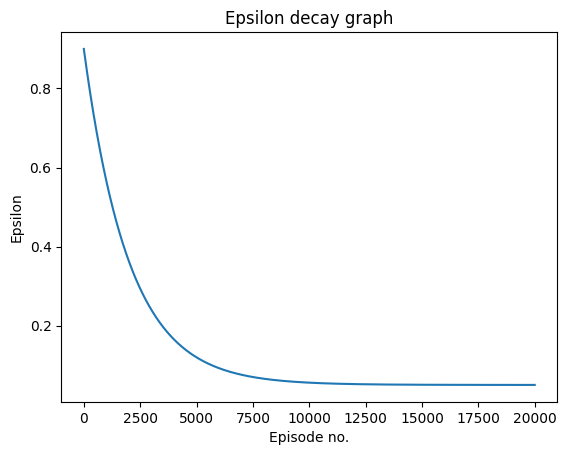

In [7]:
import matplotlib.pyplot as plt
# epilson decay graph
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 2000

steps_done = np.arange(20000)
eps = EPS_END + (EPS_START - EPS_END) * np.exp(-1 * steps_done / EPS_DECAY)
plt.plot(steps_done, eps)
plt.title('Epsilon decay graph')
plt.xlabel('Episode no.')
plt.ylabel('Epsilon')
plt.show()

In [8]:
import torch.optim as optim
import math

BATCH_SIZE = 256
GAMMA = 0.999

# get max no. of actions from action space
n_actions = env.board_width

height = env.board_height
width = env.board_width

policy_net = DQN(n_actions).to(device)
# target_net will be updated every n episodes to tell policy_net a better estimate of how far off from convergence
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
# set target_net in testing mode
target_net.eval()

optimizer = optim.Adam(policy_net.parameters())

def select_action(state, available_actions, steps_done=None, training=True):
    # batch and color channel
    state = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(dim=0).unsqueeze(dim=0)
    epsilon = random.random()
    if training:
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY)
    else:
        eps_threshold = 0

    # follow epsilon-greedy policy
    if epsilon > eps_threshold:
        with torch.no_grad():
            # action recommendations from policy net
            r_actions = policy_net(state)[0, :]
            state_action_values = [r_actions[action] for action in available_actions]
            argmax_action = np.argmax(state_action_values)
            greedy_action = available_actions[argmax_action]
            return greedy_action
    else:
        return random.choice(available_actions)

# Optmizing policy



In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    # Extract data with consistent shapes for states
    state_batch, action_batch, reward_batch, next_state_batch = zip(*[(m[0], m[1], m[2], m[3]) for m in transitions])

    # Ensure each state and next state has the correct shape (6, 7)
    state_batch = np.array([s if isinstance(s, np.ndarray) and s.shape == (6, 7) else np.zeros((6, 7)) for s in state_batch])
    next_state_batch = np.array([s if s is not None and isinstance(s, np.ndarray) and s.shape == (6, 7) else np.zeros((6, 7)) for s in next_state_batch])

    # Convert arrays to tensors and reshape to include the channel dimension
    state_batch = torch.tensor(state_batch, dtype=torch.float, device=device).unsqueeze(1)  # Shape: [BATCH_SIZE, 1, 6, 7]
    action_batch = torch.tensor([a if isinstance(a, int) else 0 for a in action_batch], dtype=torch.long, device=device)
    reward_batch = torch.tensor(reward_batch, dtype=torch.float, device=device)
    next_state_batch = torch.tensor(next_state_batch, dtype=torch.float, device=device).unsqueeze(1)  # Shape: [BATCH_SIZE, 1, 6, 7]

    # Mask for non-final states
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, next_state_batch)), device=device)

    # Compute Q-values
    state_action_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(1))
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(next_state_batch[non_final_mask]).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


# Training loop
Our agent (policy_net) will play against random agent, as a baby step, it will learn how to play and win the game at a beginner level. The agent is expected to perform better than ignorance player at the end of episodes. In short, the student is expected to outperform the teacher. It is the sole goal of training.  


In [10]:
# random agent
def random_agent(actions):
    return random.choice(actions)

# win rate test
def win_rate_test():
    win_moves_taken_list = []
    win = []
    for i in range(100):
        env.reset()
        win_moves_taken = 0

        while not env.isDone:
            state = env.board_state.copy()
            available_actions = env.get_available_actions()
            action = select_action(state, available_actions, training=False)
            state, reward = env.make_move(action, 'p1')
            win_moves_taken += 1

            if reward == 1:
                win_moves_taken_list.append(win_moves_taken)
                win.append(1)
                break

            available_actions = env.get_available_actions()
            action = random_agent(available_actions)
            state, reward = env.make_move(action, 'p2')

    return sum(win)/100, sum(win_moves_taken_list)/len(win_moves_taken_list)

In [11]:
win_rate, avg_moves = win_rate_test()
print(f"Win rate: {win_rate * 100}%")
print(f"Average moves to win: {avg_moves}")


Win rate: 86.0%
Average moves to win: 5.069767441860465


In [12]:
# avoid resetting
steps_done = 0
training_history = []

In [13]:
from itertools import count
import numpy as np

# Reduced the number of episodes for faster training
num_episodes = 2000  # Try a smaller number, e.g., 1000 or 2000
TARGET_UPDATE = 10

for i in range(num_episodes):
    env.reset()
    state_p1 = env.board_state.copy()

    # Record every 20 epochs
    if i % 20 == 19:
        win_rate, moves_taken = win_rate_test()
        training_history.append([i + 1, win_rate, moves_taken])
        th = np.array(training_history)

        # Print training message every 200 epochs
        if i % 200 == 199:
            print(f'Episode {i + 1}: | win_rate: {th[-1, 1]} | moves_taken: {th[-1, 2]}')

    for t in count():
        available_actions = env.get_available_actions()

        # Check if there are available actions for player 1
        if not available_actions:
            print("No available actions for player 1; ending episode.")
            break

        action_p1 = select_action(state_p1, available_actions, steps_done)
        steps_done += 1
        state_p1_, reward_p1 = env.make_move(action_p1, 'p1')

        if env.isDone:
            # Store reward based on outcome
            memory.dump([state_p1, action_p1, 1 if reward_p1 == 1 else 0.5, None])
            break

        # Opponent's move
        available_actions = env.get_available_actions()

        # Check if there are available actions for player 2
        if not available_actions:
            print("No available actions for player 2; ending episode.")
            break

        action_p2 = random_agent(available_actions)
        state_p2_, reward_p2 = env.make_move(action_p2, 'p2')

        if env.isDone:
            # Store punishment based on opponent's win
            memory.dump([state_p1, action_p1, -1 if reward_p2 == 1 else 0.5, None])
            break

        # Penalize for taking too long
        memory.dump([state_p1, action_p1, -0.05, state_p2_])
        state_p1 = state_p2_

        # Perform one step of the optimization
        optimize_model()

    # Update the target network
    if i % TARGET_UPDATE == TARGET_UPDATE - 1:
        target_net.load_state_dict(policy_net.state_dict())

print('Training Complete')


Episode 200: | win_rate: 0.8 | moves_taken: 6.95
Episode 400: | win_rate: 0.83 | moves_taken: 7.530120481927711
Episode 600: | win_rate: 0.73 | moves_taken: 8.10958904109589
Episode 800: | win_rate: 0.75 | moves_taken: 7.293333333333333
Episode 1000: | win_rate: 0.86 | moves_taken: 6.604651162790698
Episode 1200: | win_rate: 0.8 | moves_taken: 7.15
Episode 1400: | win_rate: 0.8 | moves_taken: 6.0875
Episode 1600: | win_rate: 0.83 | moves_taken: 6.530120481927711
Episode 1800: | win_rate: 0.85 | moves_taken: 6.258823529411765
Episode 2000: | win_rate: 0.76 | moves_taken: 6.026315789473684
Training Complete


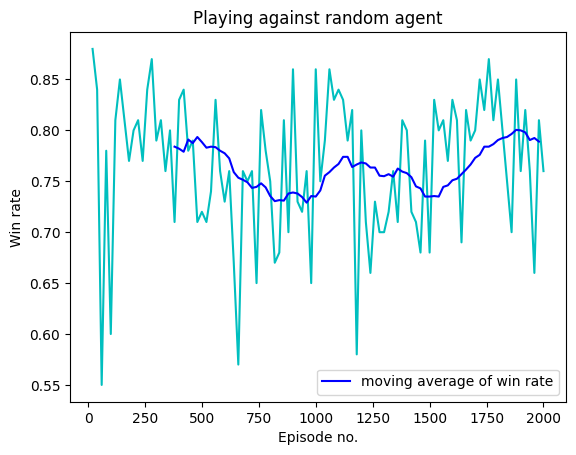

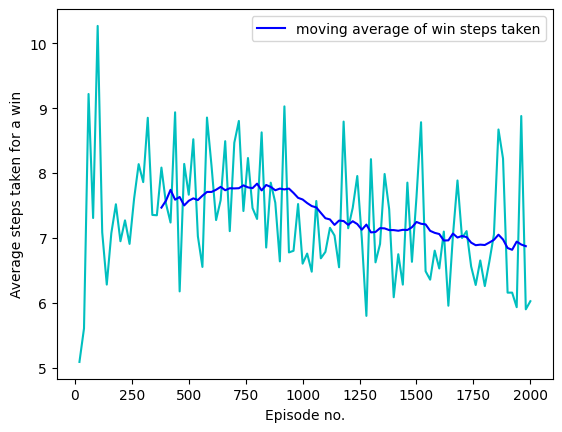

In [14]:
plt.plot(th[:, 0], th[:, 1], c='c')
win_rate_moving_average = np.array([[(i + 19) * 20, np.mean(th[i: i + 20, 1])] for i in range(len(th) - 19)])
plt.plot(win_rate_moving_average[:, 0], win_rate_moving_average[:, 1], c='b', label='moving average of win rate')
plt.legend()
plt.title('Playing against random agent')
plt.xlabel('Episode no.')
plt.ylabel('Win rate')
plt.show()

plt.plot(th[:, 0], th[:, 2], c='c')
win_steps_taken_moving_average = np.array([[(i + 19) * 20, np.mean(th[i: i + 20, 2])] for i in range(len(th) - 19)])
plt.plot(win_steps_taken_moving_average[:, 0], win_steps_taken_moving_average[:, 1], c='b', label='moving average of win steps taken')
plt.legend()
plt.xlabel('Episode no.')
plt.ylabel('Average steps taken for a win')
plt.show()

As one can see from the graph above,
* The variance of win rate is getting smaller and the moving average for win rate is also getting higher.
* The average win steps taken has gone down, which means the agent has learnt to win as fast as possible.

Both are the indication of the fact that our agent has learnt how to win Connect 4.

In [15]:
path = 'DQN_plainCNN.pth'
torch.save(policy_net.state_dict(), path)

# Demonstration of a trained agent playing a game

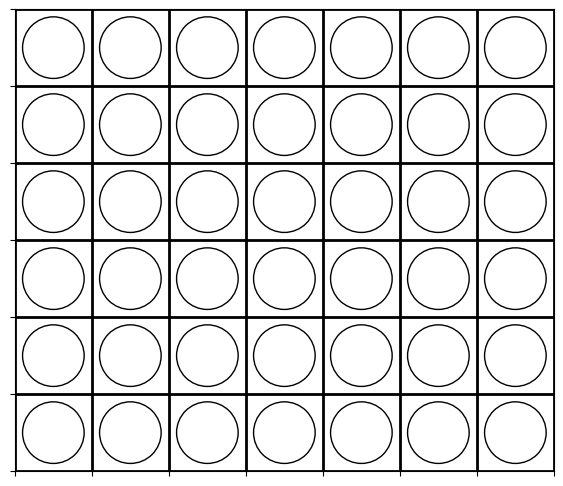

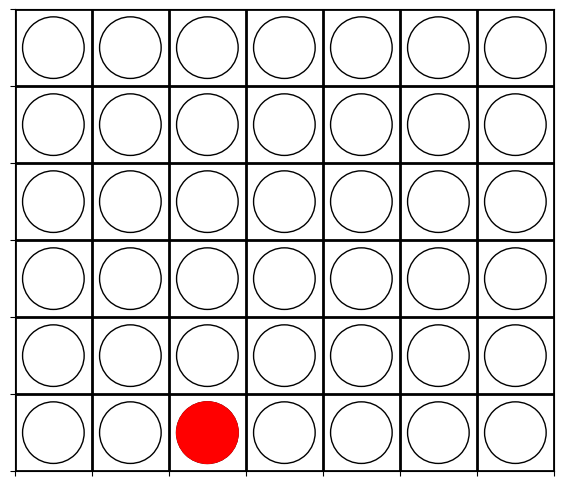

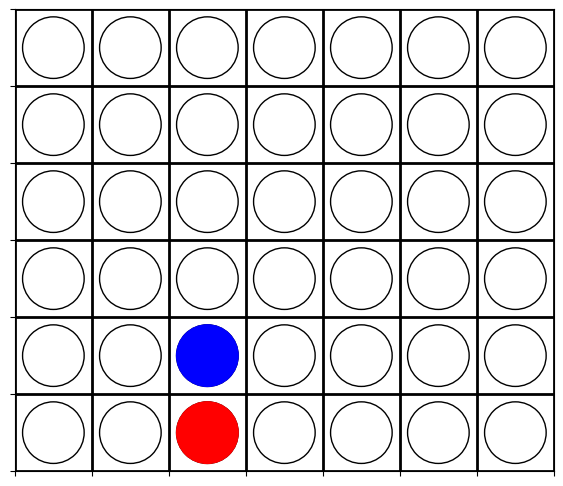

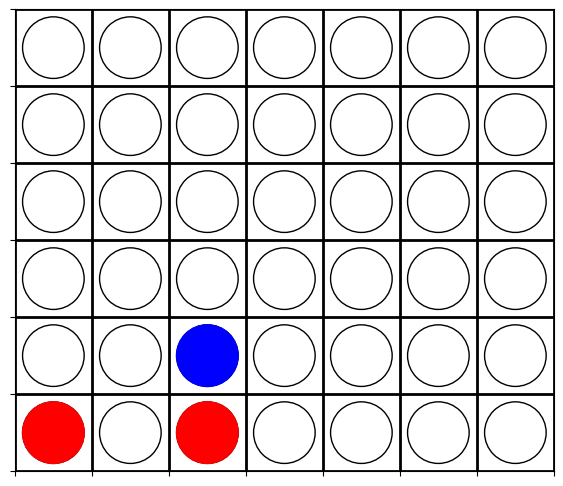

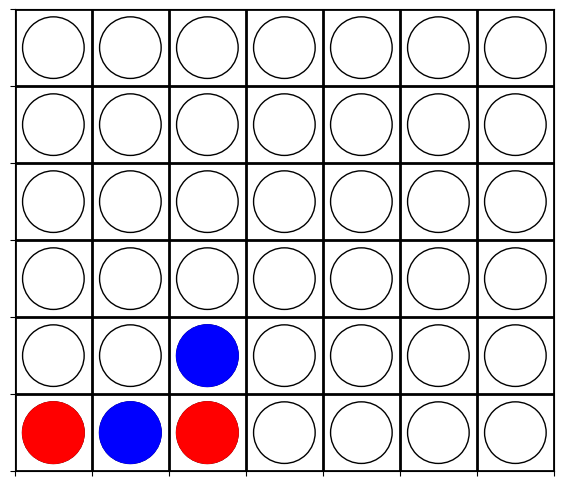

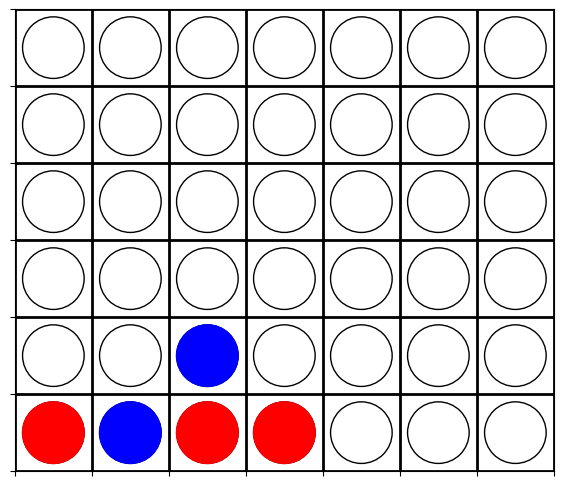

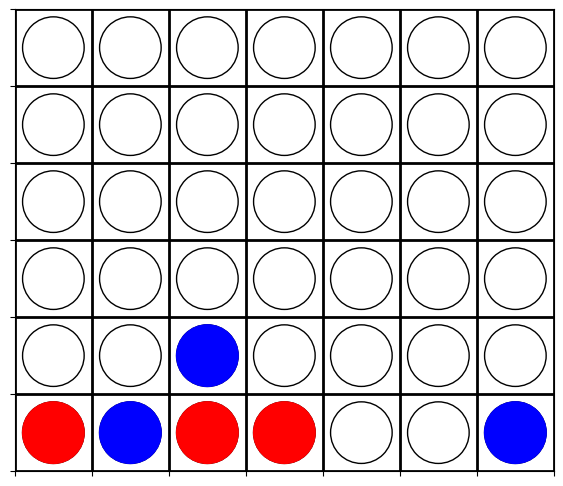

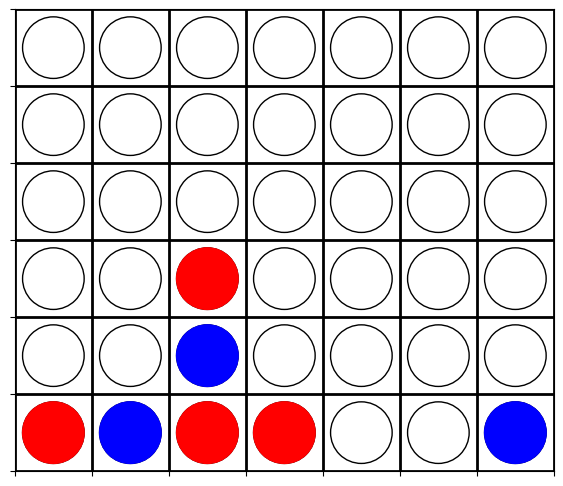

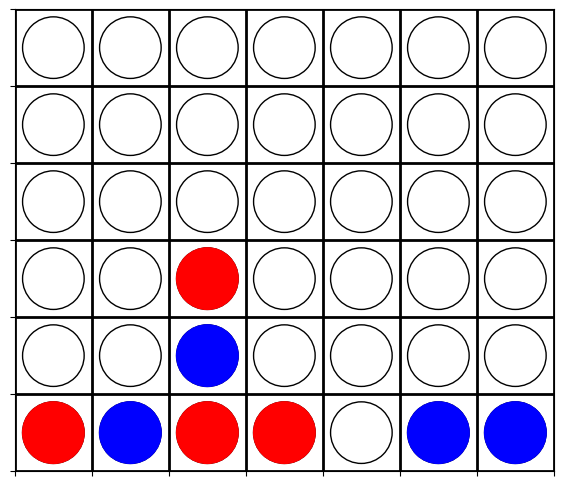

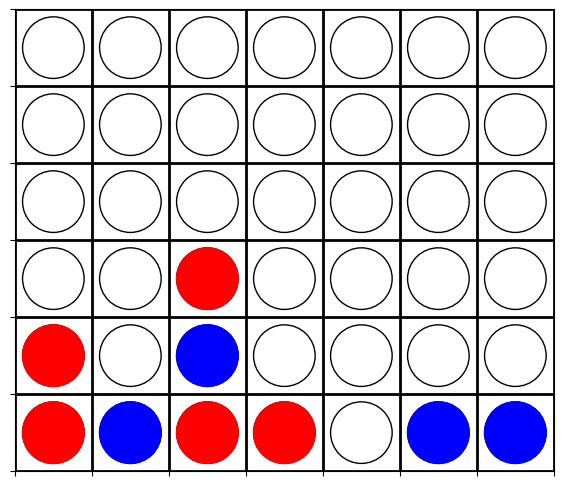

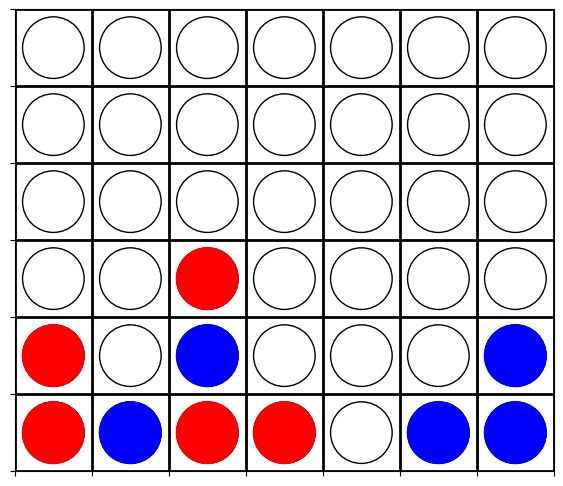

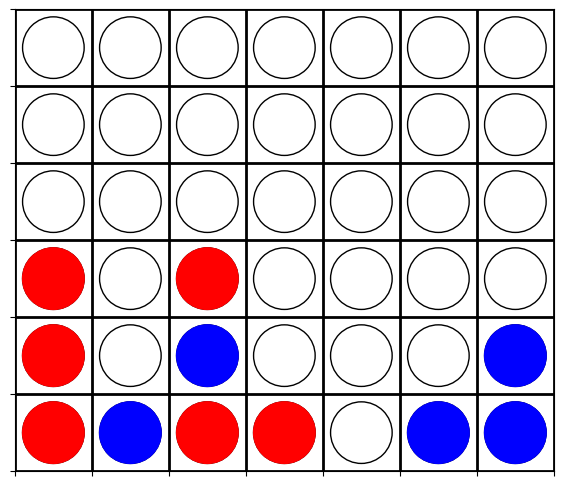

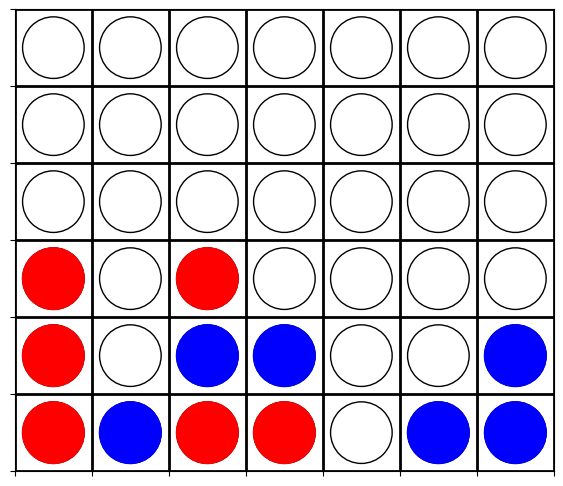

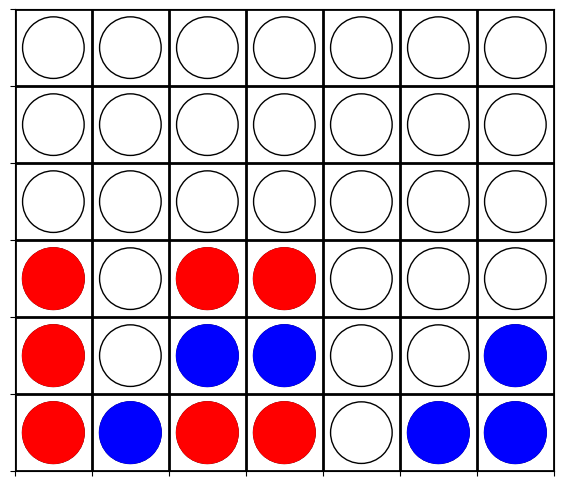

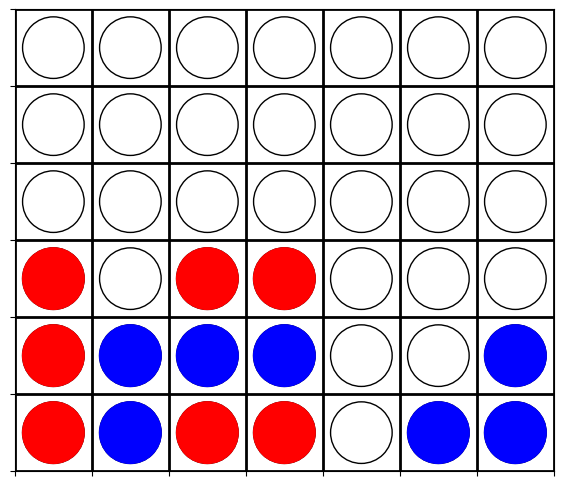

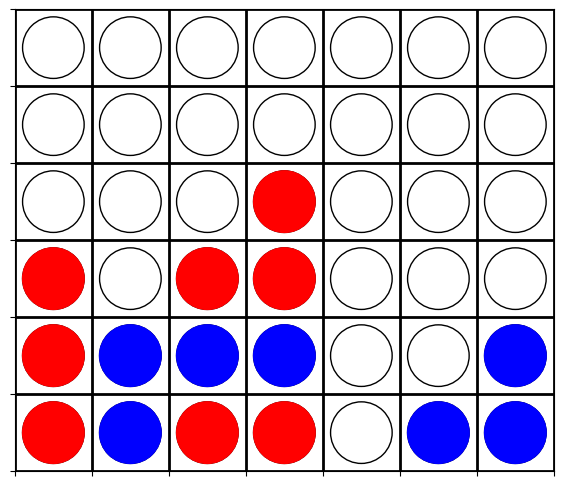

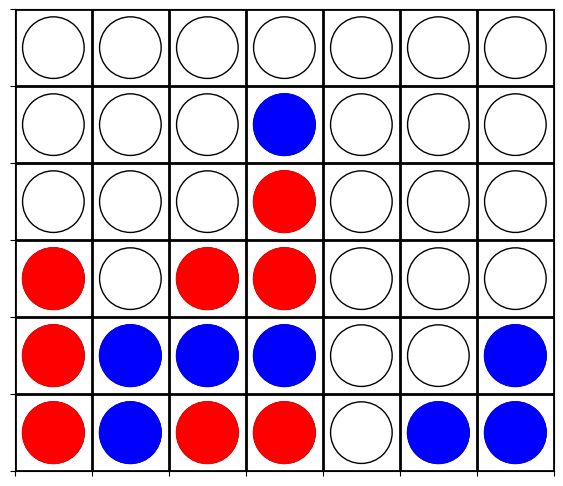

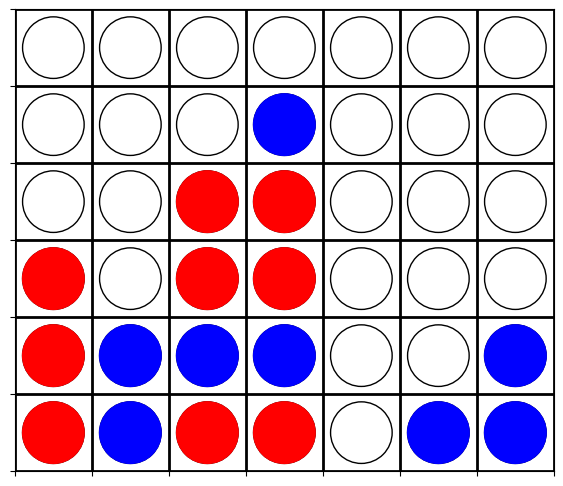

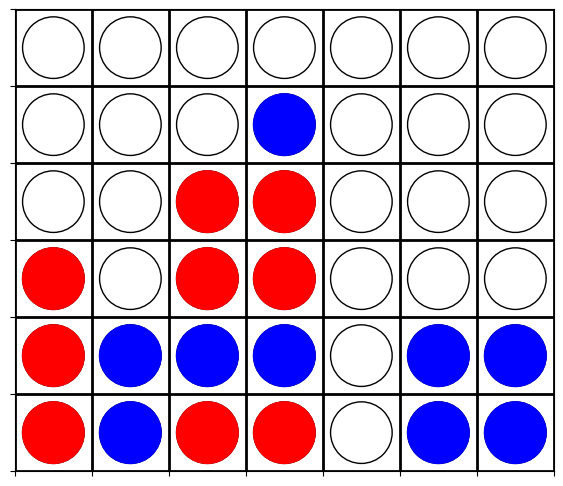

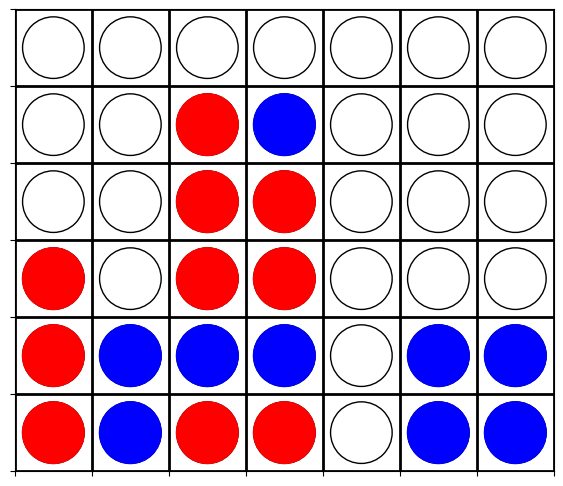

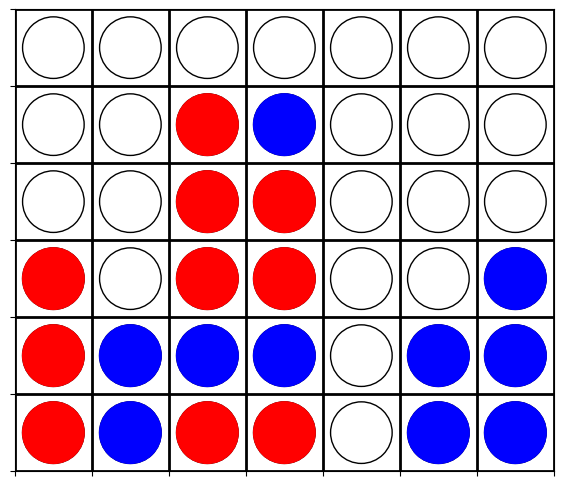

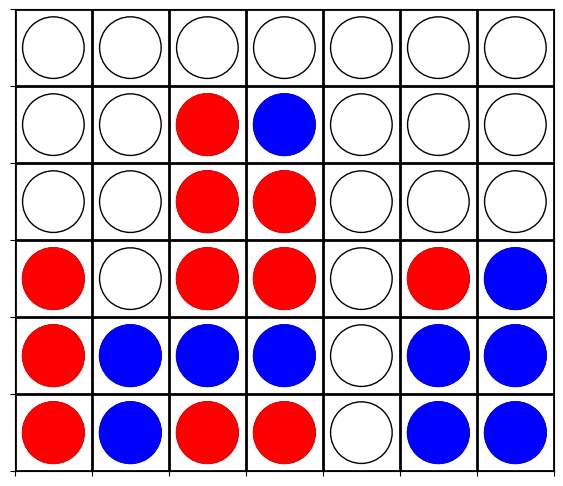

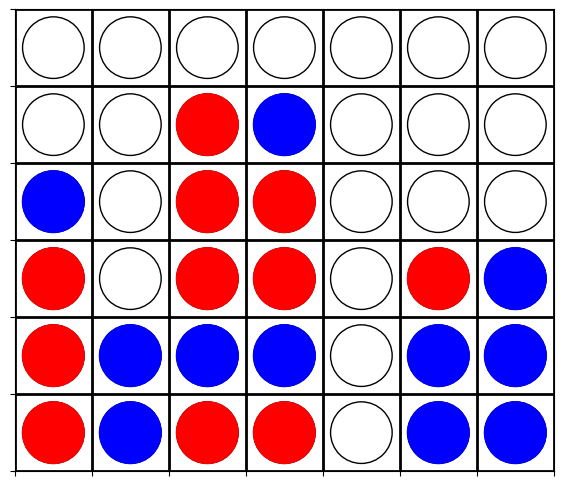

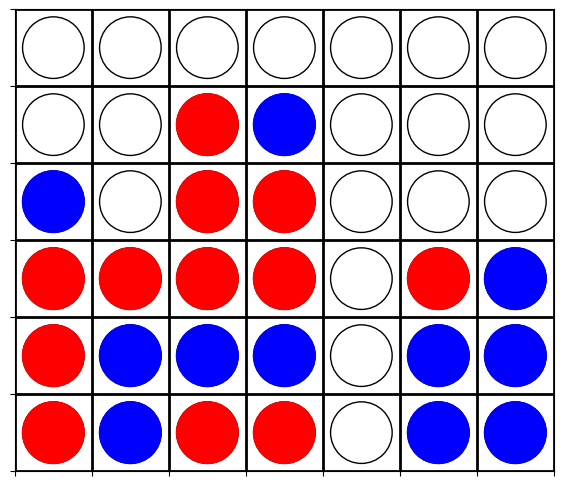

In [21]:
def demo():
    env.reset()
    env.render()

    while not env.isDone:
        state = env.board_state.copy()
        available_actions = env.get_available_actions()
        action = select_action(state, available_actions, training=False)
        # trained agent's move is denoted by O
        state, reward = env.make_move(action, 'p1')
        env.render()

        if reward == 1:
            break

        available_actions = env.get_available_actions()
        action = random_agent(available_actions)
        state, reward = env.make_move(action, 'p2')
        env.render()

demo()

# **Conclusion**

In this project, we developed a Deep Q-Network (DQN) model to play the game of Connect-4 using reinforcement learning. The DQN approach enables the agent to learn optimal strategies by maximizing cumulative rewards through exploration and exploitation. The model utilized a convolutional neural network to process board states and an epsilon-greedy policy to balance the exploration of new moves with the exploitation of known successful moves. Training stability was enhanced using experience replay and a target network, helping the model converge towards optimal play over many episodes.

The results demonstrate that the agent successfully learned to play Connect-4 by consistently improving its win rate and reducing the average steps needed to secure a win, as evidenced by the trends observed in the win rate and step count graphs. The epsilon decay graph also confirmed that the model became more exploitative as training progressed, showing a reduced dependency on random actions.

Overall, the project highlights the effectiveness of DQNs in mastering complex board games, like Connect-4, by leveraging neural networks and reinforcement learning principles. Potential improvements include experimenting with alternative reward structures, adjusting the network architecture, and incorporating more advanced techniques such as Double DQN or prioritized experience replay to further enhance learning stability and performance. This work lays a foundation for exploring reinforcement learning in more complex environments and demonstrates the power of DQNs in achieving human-level gameplay in strategic games.






